In [ ]:
# Swin Transformer V2 implementation reused from
# https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/resnet_family/resnet_deep.py
# - data preprocessing and brief EDA inspired by https://www.kaggle.com/code/tiletisaitejareddy/malware-classification-ism

In [2]:
# Dependencies
import sys
import os
from math import log
import numpy as np
import pandas as pd
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

# Data Preprocessing and Basic EDA

In [3]:
# prepare the data

train_root_path = "./malimg_dataset/train"
val_root_path = "./malimg_dataset/validation"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=train_root_path, target_size=(64,64), batch_size=10000)

Found 6527 images belonging to 25 classes.


In [4]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [5]:
imgs, labels = next(batches)
imgs.shape

(6527, 64, 64, 3)

In [6]:
labels.shape

(6527, 25)

In [7]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

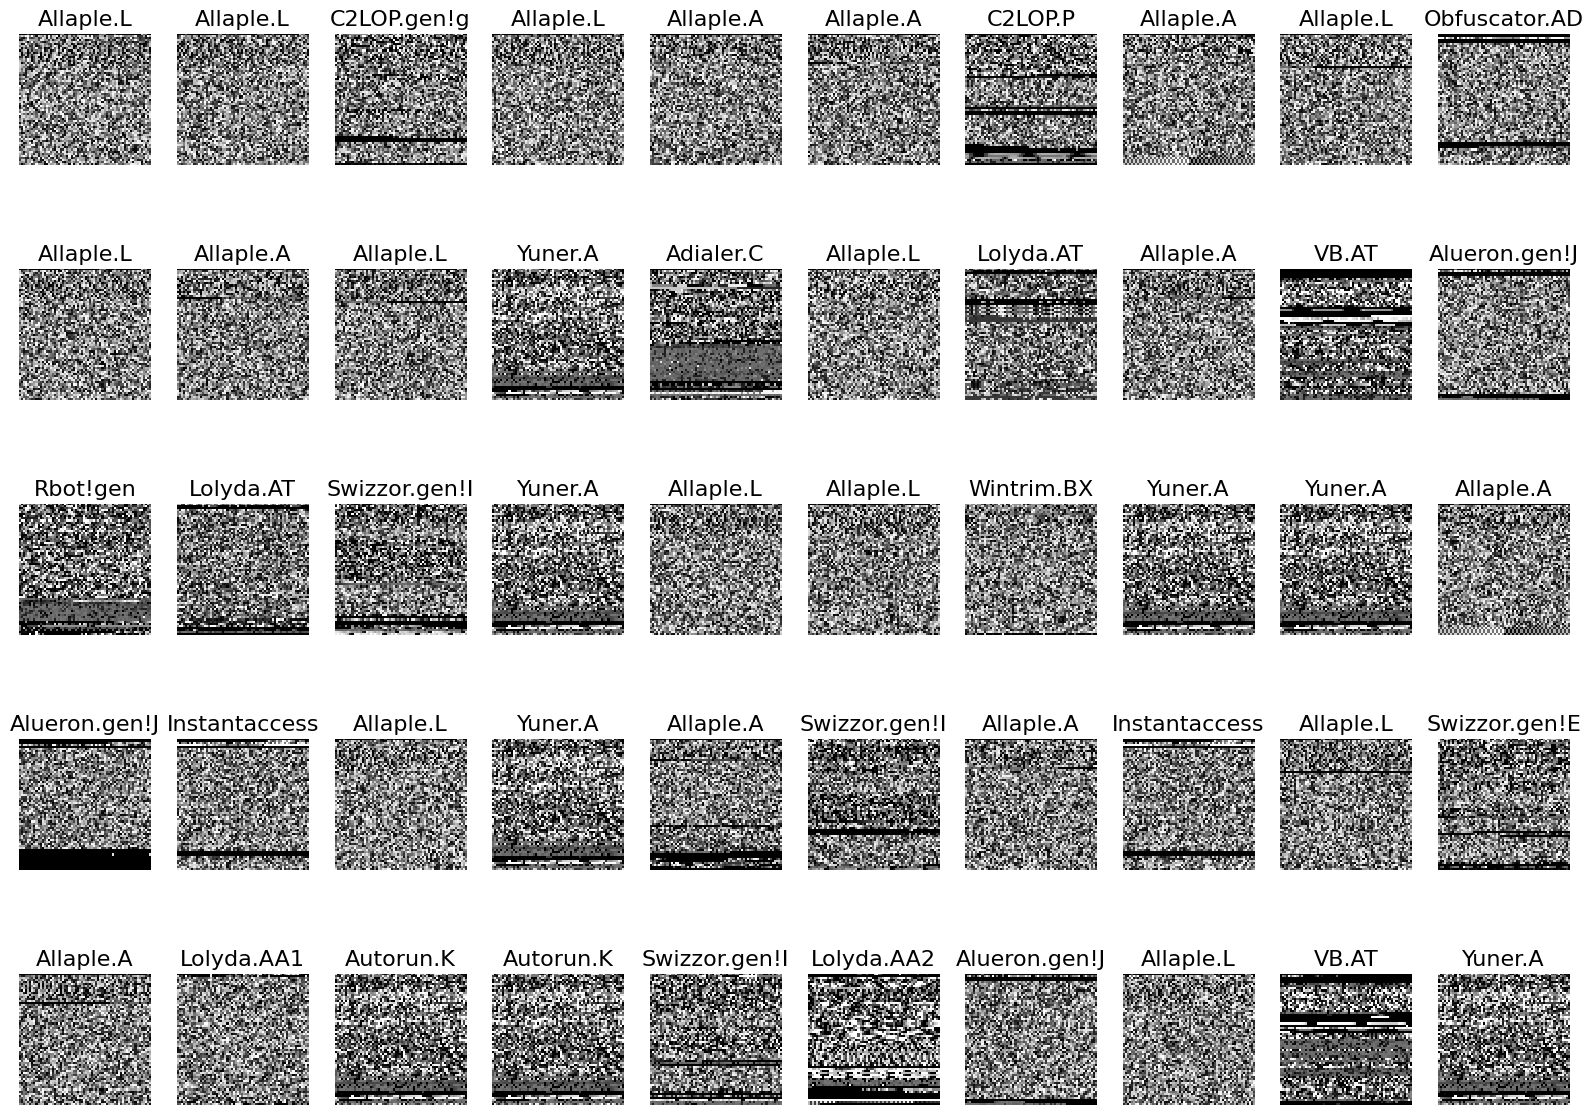

In [8]:
plots(imgs, titles = labels)

<BarContainer object of 25 artists>

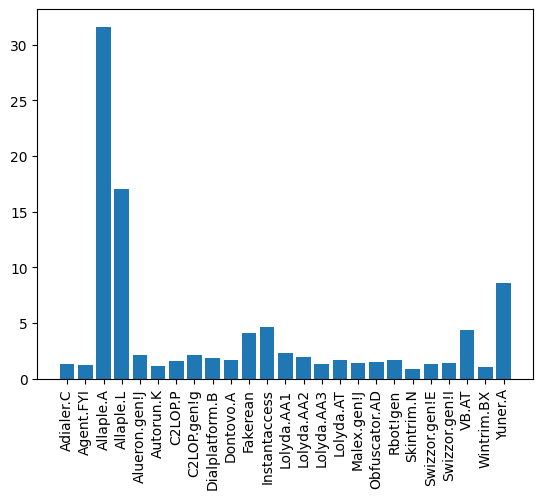

In [9]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [11]:
x_train.shape

(4568, 64, 64, 3)

In [12]:
y_test.shape

(1959, 25)

In [13]:
num_classes = len(classes)
# we do not need to apply one-hot encoding to the labels as in https://keras.io/examples/vision/swin_transformers/
# since the dataset data is already prepared for the multi-class classification
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4568, 64, 64, 3) - y_train shape: (4568, 25)
x_test shape: (1959, 64, 64, 3) - y_test shape: (1959, 25)


# ResNet Model

In [29]:
from tensorflow.keras.applications import (
    ResNet50, ResNet101, ResNet152,
    DenseNet121, DenseNet169, DenseNet201
)
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

def get_model(model_name, input_shape=(64, 64, 3), num_classes=25, pretrained=False):
    weights = 'imagenet' if pretrained else None

    if model_name == 'resnet50':
        base_model = ResNet50(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = resnet_preprocess
    elif model_name == 'resnet101':
        base_model = ResNet101(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = resnet_preprocess
    elif model_name == 'resnet152':
        base_model = ResNet152(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = resnet_preprocess
    elif model_name == 'densenet121':
        base_model = DenseNet121(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = densenet_preprocess
    elif model_name == 'densenet169':
        base_model = DenseNet169(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = densenet_preprocess
    elif model_name == 'densenet201':
        base_model = DenseNet201(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = densenet_preprocess
    else:
        raise ValueError(f"Model '{model_name}' is not supported.")

    from tensorflow.keras import layers, models

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, preprocess


In [30]:
model, preprocess_input = get_model(
    model_name='resnet152',
    input_shape=(64, 64, 3),
    num_classes=25,
    pretrained=False  # or True if testing practical benefit
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2, 2, 2048)        58370944  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 25)                51225     
                                                                 
Total params: 58422169 (222.86 MB)
Trainable params: 58270745 (222.29 MB)
Non-trainable params: 151424 (591.50 KB)
_________________________________________________________________


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_data_generators(train_dir, val_dir, test_dir, preprocess_input, target_size=(64, 64), batch_size=128):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_gen = datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_gen = datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Important for confusion matrix
    )

    return train_gen, val_gen, test_gen

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def train_model(model, train_gen, val_gen, model_name, epochs=40):
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5),
        ModelCheckpoint(f'models/{model_name}.h5', save_best_only=True),
        ResourceLogger()
    ]

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

In [22]:
from tensorflow.keras.callbacks import Callback
import time, GPUtil, psutil

class ResourceLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gpus = GPUtil.getGPUs()
        for gpu in gpus:
            print(f"[Epoch {epoch+1}] GPU {gpu.id}: {gpu.memoryUsed}MB / {gpu.memoryTotal}MB used | Load: {gpu.load*100:.1f}%")
        mem = psutil.virtual_memory()
        print(f"[Epoch {epoch+1}] CPU RAM: {mem.used / 1e6:.2f}MB used / {mem.total / 1e6:.2f}MB total")

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_gen, class_names):
    y_pred = model.predict(test_gen)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    print(classification_report(y_true, y_pred_labels, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Found 6527 images belonging to 25 classes.
Found 1401 images belonging to 25 classes.
Found 1411 images belonging to 25 classes.
Epoch 1/40
51/51 [==============================] - 69s 990ms/step - loss: 1.5449 - accuracy: 0.5773 - val_loss: 50.1513 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/40
51/51 [==============================] - 49s 954ms/step - loss: 0.5651 - accuracy: 0.8506 - val_loss: 3.8849 - val_accuracy: 0.3155 - lr: 0.0010
Epoch 3/40
51/51 [==============================] - 48s 926ms/step - loss: 0.2483 - accuracy: 0.9501 - val_loss: 3.9353 - val_accuracy: 0.3276 - lr: 0.0010
Epoch 4/40
51/51 [==============================] - 48s 937ms/step - loss: 0.1384 - accuracy: 0.9720 - val_loss: 1.7415 - val_accuracy: 0.5218 - lr: 0.0010
Epoch 5/40
51/51 [==============================] - 49s 955ms/step - loss: 0.1605 - accuracy: 0.9740 - val_loss: 1.5862 - val_accuracy: 0.5596 - lr: 0.0010
Epoch 6/40
51/51 [==============================] - 49s 950ms/step - loss: 0.0664 - ac

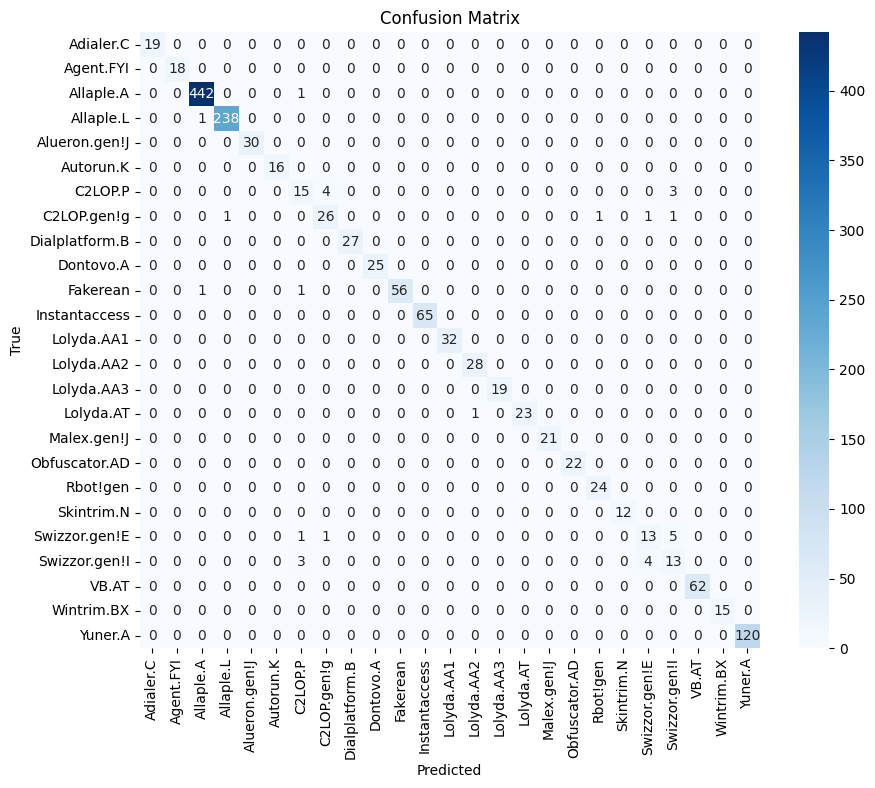

In [30]:
model_name = 'resnet50'
model, preprocess = get_model(model_name, pretrained=False)
train_gen, val_gen, test_gen = get_data_generators(
    'malimg_dataset/train', 'malimg_dataset/val', 'malimg_dataset/test',
    preprocess_input=preprocess
)
history = train_model(model, train_gen, val_gen, model_name=model_name)
evaluate_model(model, test_gen, class_names=list(train_gen.class_indices.keys()))

Found 6527 images belonging to 25 classes.
Found 1401 images belonging to 25 classes.
Found 1411 images belonging to 25 classes.
Epoch 1/40
51/51 [==============================] - ETA: 0s - loss: 1.9987 - accuracy: 0.5154

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 124s 2s/step - loss: 1.9987 - accuracy: 0.5154 - val_loss: 2.3743 - val_accuracy: 0.2184 - lr: 0.0010
Epoch 2/40
51/51 [==============================] - 85s 2s/step - loss: 0.9132 - accuracy: 0.7472 - val_loss: 6.0399 - val_accuracy: 0.1706 - lr: 0.0010
Epoch 3/40
51/51 [==============================] - 81s 2s/step - loss: 0.3120 - accuracy: 0.9124 - val_loss: 7.2644 - val_accuracy: 0.1706 - lr: 0.0010
Epoch 4/40
51/51 [==============================] - 84s 2s/step - loss: 0.1835 - accuracy: 0.9576 - val_loss: 5.2525 - val_accuracy: 0.1856 - lr: 0.0010
Epoch 5/40
51/51 [==============================] - 80s 2s/step - loss: 0.1176 - accuracy: 0.9786 - val_loss: 4.9247 - val_accuracy: 0.3076 - lr: 5.0000e-04
Epoch 6/40
51/51 [==============================] - 81s 2s/step - loss: 0.0922 - accuracy: 0.9833 - val_loss: 2.1947 - val_accuracy: 0.5196 - lr: 5.0000e-04
Epoch 7/40
51/51 [==============================] - 83s 2s/step - loss: 0.0149 - acc

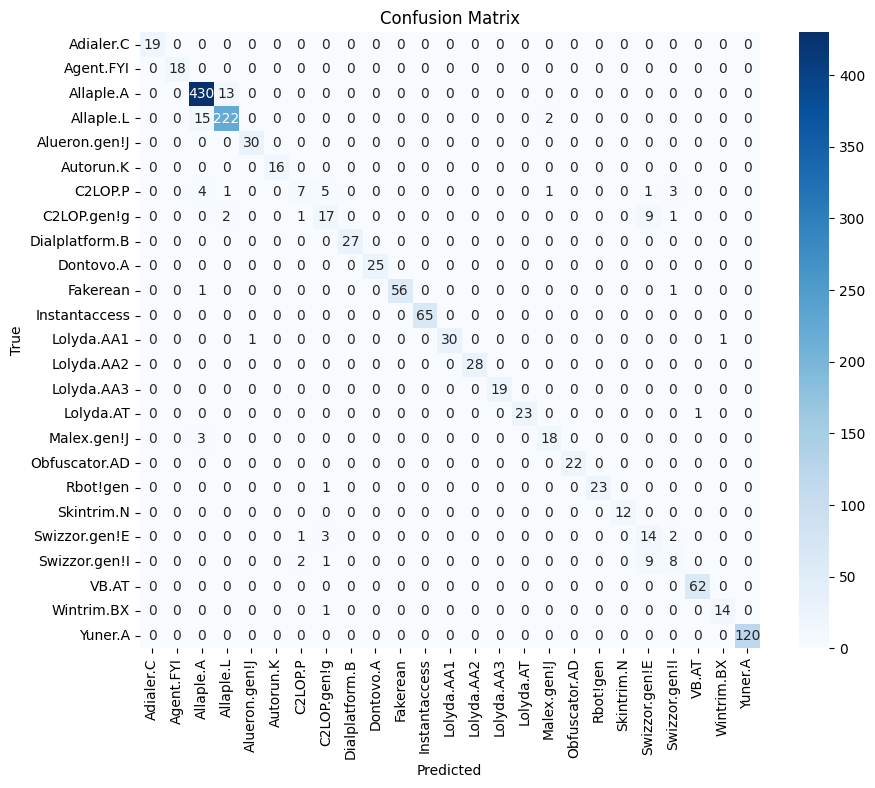

In [31]:
model_name = 'resnet101'
model, preprocess = get_model(model_name, pretrained=False)
train_gen, val_gen, test_gen = get_data_generators(
    'malimg_dataset/train', 'malimg_dataset/val', 'malimg_dataset/test',
    preprocess_input=preprocess
)
history = train_model(model, train_gen, val_gen, model_name=model_name)
evaluate_model(model, test_gen, class_names=list(train_gen.class_indices.keys()))

Found 6527 images belonging to 25 classes.
Found 1401 images belonging to 25 classes.
Found 1411 images belonging to 25 classes.
Epoch 1/40
51/51 [==============================] - ETA: 0s - loss: 1.8665 - accuracy: 0.4826

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 1] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 1] CPU RAM: 22591.09MB used / 574461.89MB total
51/51 [==============================] - 192s 3s/step - loss: 1.8665 - accuracy: 0.4826 - val_loss: 2.5681 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 2/40
51/51 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.6887[Epoch 2] GPU 0: 79596.0MB / 81920.0MB used | Load: 84.0%
[Epoch 2] CPU RAM: 22945.93MB used / 574461.89MB total
51/51 [==============================] - 121s 2s/step - loss: 1.0054 - accuracy: 0.6887 - val_loss: 5.9931 - val_accuracy: 0.3155 - lr: 0.0010
Epoch 3/40
51/51 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.8272[Epoch 3] GPU 0: 79596.0MB / 81920.0MB used | Load: 6.0%
[Epoch 3] CPU RAM: 23086.30MB used / 574461.89MB total
51/51 [==============================] - 121s 2s/step - loss: 0.6283 - accuracy: 0.8272 - val_loss: 8.1376 - val_accuracy: 0.3155 - lr: 0.0010
Epoch 4/40
51/51 [==============================

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

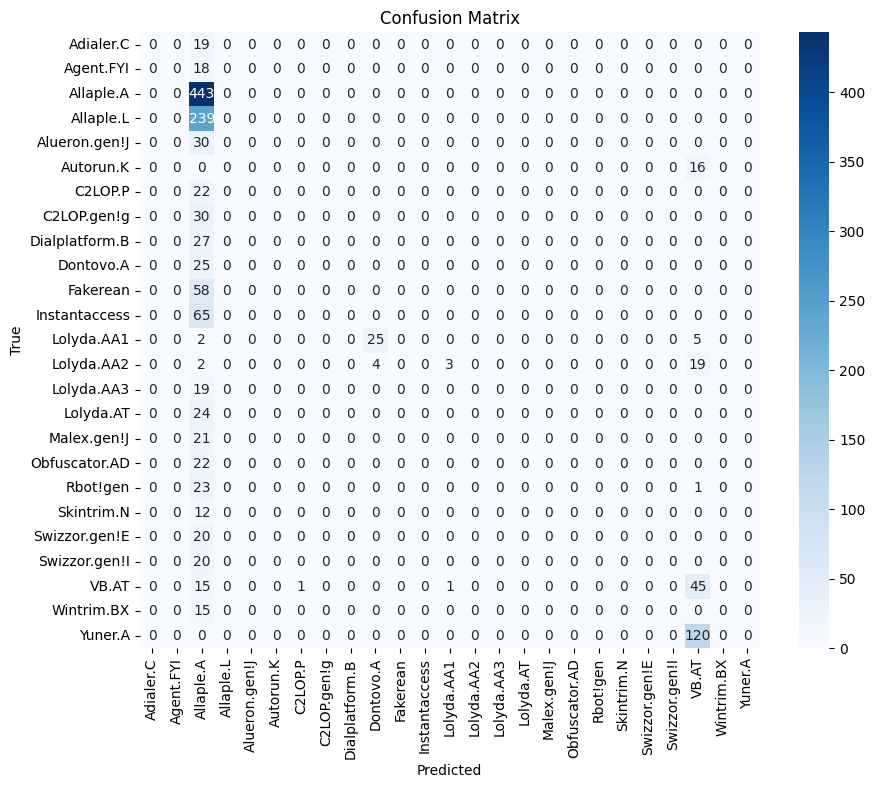

In [31]:
model_name = 'resnet152'
model, preprocess = get_model(model_name, pretrained=False)
train_gen, val_gen, test_gen = get_data_generators(
    'malimg_dataset/train', 'malimg_dataset/val', 'malimg_dataset/test',
    preprocess_input=preprocess
)
history = train_model(model, train_gen, val_gen, model_name=model_name)
evaluate_model(model, test_gen, class_names=list(train_gen.class_indices.keys()))

# DenseNet

Found 6527 images belonging to 25 classes.
Found 1401 images belonging to 25 classes.
Found 1411 images belonging to 25 classes.
Epoch 1/40
51/51 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.8106

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 1] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 1] CPU RAM: 23414.05MB used / 574461.89MB total
51/51 [==============================] - 84s 946ms/step - loss: 0.6207 - accuracy: 0.8106 - val_loss: 2.2344 - val_accuracy: 0.3176 - lr: 0.0010
Epoch 2/40
51/51 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9672[Epoch 2] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 2] CPU RAM: 23515.09MB used / 574461.89MB total
51/51 [==============================] - 44s 869ms/step - loss: 0.0940 - accuracy: 0.9672 - val_loss: 2.8445 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 3/40
51/51 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9804

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 3] GPU 0: 79596.0MB / 81920.0MB used | Load: 85.0%
[Epoch 3] CPU RAM: 23733.13MB used / 574461.89MB total
51/51 [==============================] - 45s 869ms/step - loss: 0.0554 - accuracy: 0.9804 - val_loss: 1.8668 - val_accuracy: 0.5318 - lr: 0.0010
Epoch 4/40
51/51 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9822

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 4] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 4] CPU RAM: 23968.24MB used / 574461.89MB total
51/51 [==============================] - 45s 885ms/step - loss: 0.0540 - accuracy: 0.9822 - val_loss: 1.5172 - val_accuracy: 0.6089 - lr: 0.0010
Epoch 5/40
51/51 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9880

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 5] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 5] CPU RAM: 24154.45MB used / 574461.89MB total
51/51 [==============================] - 45s 873ms/step - loss: 0.0371 - accuracy: 0.9880 - val_loss: 0.5906 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 6/40
51/51 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9789[Epoch 6] GPU 0: 79596.0MB / 81920.0MB used | Load: 21.0%
[Epoch 6] CPU RAM: 24256.74MB used / 574461.89MB total
51/51 [==============================] - 45s 877ms/step - loss: 0.0735 - accuracy: 0.9789 - val_loss: 1.0385 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 7/40
51/51 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9903[Epoch 7] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 7] CPU RAM: 24178.16MB used / 574461.89MB total
51/51 [==============================] - 44s 849ms/step - loss: 0.0257 - accuracy: 0.9903 - val_loss: 2.0108 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 8/40
51/51 [========================

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 8] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 8] CPU RAM: 24241.79MB used / 574461.89MB total
51/51 [==============================] - 45s 870ms/step - loss: 0.0193 - accuracy: 0.9931 - val_loss: 0.2098 - val_accuracy: 0.9265 - lr: 0.0010
Epoch 9/40
51/51 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9971

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 9] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 9] CPU RAM: 24354.29MB used / 574461.89MB total
51/51 [==============================] - 46s 908ms/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.1990 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 10/40
51/51 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9971[Epoch 10] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 10] CPU RAM: 24327.63MB used / 574461.89MB total
51/51 [==============================] - 43s 841ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.2201 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 11/40
51/51 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9960

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 11] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 11] CPU RAM: 24410.70MB used / 574461.89MB total
51/51 [==============================] - 45s 870ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.1075 - val_accuracy: 0.9757 - lr: 0.0010
Epoch 12/40
51/51 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9988[Epoch 12] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 12] CPU RAM: 24433.09MB used / 574461.89MB total
51/51 [==============================] - 43s 830ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.1403 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 13/40
51/51 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9986

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 13] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 13] CPU RAM: 24427.59MB used / 574461.89MB total
51/51 [==============================] - 44s 855ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.1009 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 14/40
51/51 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9985[Epoch 14] GPU 0: 79596.0MB / 81920.0MB used | Load: 5.0%
[Epoch 14] CPU RAM: 24655.57MB used / 574461.89MB total
51/51 [==============================] - 44s 860ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.1234 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 15/40
51/51 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9983[Epoch 15] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 15] CPU RAM: 24528.57MB used / 574461.89MB total
51/51 [==============================] - 43s 838ms/step - loss: 0.0038 - accuracy: 0.9983 - val_loss: 0.4195 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 16/40
51/51 [================

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 17] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 17] CPU RAM: 24611.00MB used / 574461.89MB total
51/51 [==============================] - 45s 869ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.0877 - val_accuracy: 0.9829 - lr: 5.0000e-04
Epoch 18/40
51/51 [==============================] - ETA: 0s - loss: 5.7838e-04 - accuracy: 1.0000

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 18] GPU 0: 79596.0MB / 81920.0MB used | Load: 3.0%
[Epoch 18] CPU RAM: 24670.94MB used / 574461.89MB total
51/51 [==============================] - 45s 867ms/step - loss: 5.7838e-04 - accuracy: 1.0000 - val_loss: 0.0827 - val_accuracy: 0.9836 - lr: 5.0000e-04
Epoch 19/40
51/51 [==============================] - ETA: 0s - loss: 2.8139e-04 - accuracy: 1.0000[Epoch 19] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 19] CPU RAM: 24641.04MB used / 574461.89MB total
51/51 [==============================] - 43s 837ms/step - loss: 2.8139e-04 - accuracy: 1.0000 - val_loss: 0.0835 - val_accuracy: 0.9843 - lr: 5.0000e-04
Epoch 20/40
51/51 [==============================] - ETA: 0s - loss: 1.4171e-04 - accuracy: 1.0000

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 20] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 20] CPU RAM: 24675.92MB used / 574461.89MB total
51/51 [==============================] - 46s 893ms/step - loss: 1.4171e-04 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.9850 - lr: 5.0000e-04
Epoch 21/40
51/51 [==============================] - ETA: 0s - loss: 1.3013e-04 - accuracy: 1.0000[Epoch 21] GPU 0: 79596.0MB / 81920.0MB used | Load: 37.0%
[Epoch 21] CPU RAM: 24663.92MB used / 574461.89MB total
51/51 [==============================] - 45s 870ms/step - loss: 1.3013e-04 - accuracy: 1.0000 - val_loss: 0.0820 - val_accuracy: 0.9857 - lr: 5.0000e-04
Epoch 22/40
51/51 [==============================] - ETA: 0s - loss: 1.0140e-04 - accuracy: 1.0000

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 22] GPU 0: 79596.0MB / 81920.0MB used | Load: 25.0%
[Epoch 22] CPU RAM: 24779.10MB used / 574461.89MB total
51/51 [==============================] - 41s 807ms/step - loss: 1.0140e-04 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.9850 - lr: 5.0000e-04
Epoch 23/40
51/51 [==============================] - ETA: 0s - loss: 1.0455e-04 - accuracy: 1.0000[Epoch 23] GPU 0: 79596.0MB / 81920.0MB used | Load: 0.0%
[Epoch 23] CPU RAM: 25029.69MB used / 574461.89MB total
51/51 [==============================] - 45s 881ms/step - loss: 1.0455e-04 - accuracy: 1.0000 - val_loss: 0.0818 - val_accuracy: 0.9850 - lr: 5.0000e-04
Epoch 24/40
51/51 [==============================] - ETA: 0s - loss: 9.7004e-05 - accuracy: 1.0000[Epoch 24] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 24] CPU RAM: 25056.35MB used / 574461.89MB total
51/51 [==============================] - 44s 859ms/step - loss: 9.7004e-05 - accuracy: 1.0000 - val_loss: 0.0825 - val_accuracy: 0.9850 - lr: 2.5000e-04
Ep

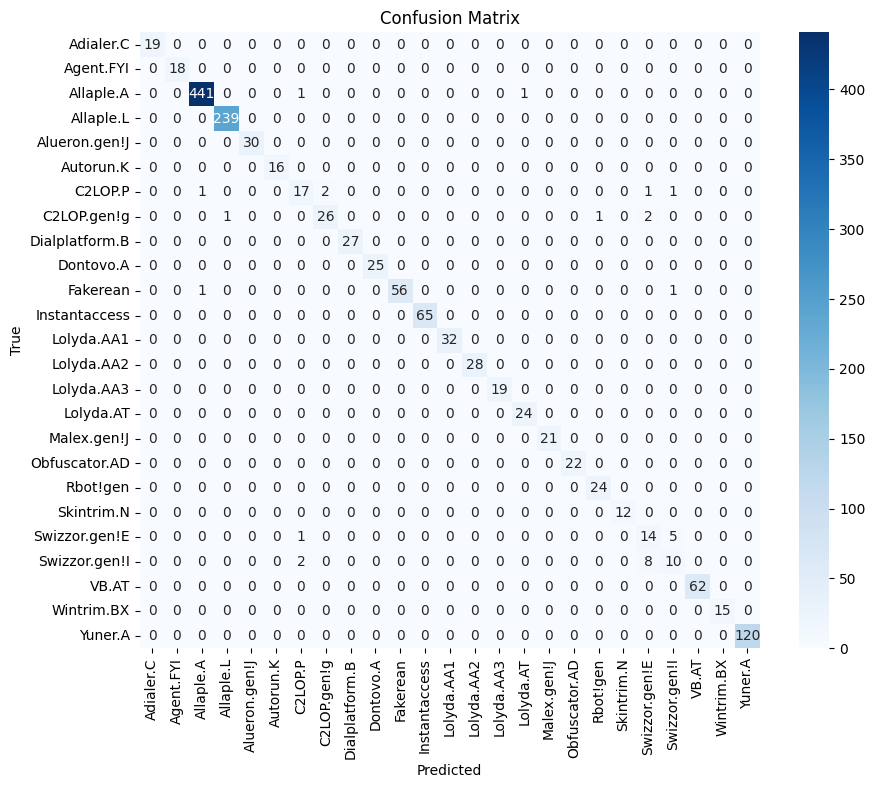

In [33]:
model_name = 'densenet121'
model, preprocess = get_model(model_name, pretrained=False)
train_gen, val_gen, test_gen = get_data_generators(
    'malimg_dataset/train', 'malimg_dataset/val', 'malimg_dataset/test',
    preprocess_input=preprocess
)
history = train_model(model, train_gen, val_gen, model_name=model_name)
evaluate_model(model, test_gen, class_names=list(train_gen.class_indices.keys()))

In [35]:
# Get DenseNet169 Parameter and Size Information
model, preprocess_input = get_model(
    model_name='densenet169',
    input_shape=(64, 64, 3),
    num_classes=25,
    pretrained=False  # or True if testing practical benefit
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 2, 2, 1664)        12642880  
                                                                 
 global_average_pooling2d_5  (None, 1664)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 1664)              0         
                                                                 
 dense_5 (Dense)             (None, 25)                41625     
                                                                 
Total params: 12684505 (48.39 MB)
Trainable params: 12526105 (47.78 MB)
Non-trainable params: 158400 (618.75 KB)
_________________________________________________________________


Found 6527 images belonging to 25 classes.
Found 1401 images belonging to 25 classes.
Found 1411 images belonging to 25 classes.
Epoch 1/40
51/51 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.8008

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 1] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 1] CPU RAM: 24724.68MB used / 574461.89MB total
51/51 [==============================] - 111s 1s/step - loss: 0.6166 - accuracy: 0.8008 - val_loss: 2.3389 - val_accuracy: 0.3762 - lr: 0.0010
Epoch 2/40
51/51 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9652[Epoch 2] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 2] CPU RAM: 24932.88MB used / 574461.89MB total
51/51 [==============================] - 55s 1s/step - loss: 0.0996 - accuracy: 0.9652 - val_loss: 2.4205 - val_accuracy: 0.4954 - lr: 0.0010
Epoch 3/40
51/51 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9810

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 3] GPU 0: 79596.0MB / 81920.0MB used | Load: 73.0%
[Epoch 3] CPU RAM: 25050.00MB used / 574461.89MB total
51/51 [==============================] - 56s 1s/step - loss: 0.0573 - accuracy: 0.9810 - val_loss: 2.2010 - val_accuracy: 0.4311 - lr: 0.0010
Epoch 4/40
51/51 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9835

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 4] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 4] CPU RAM: 25191.63MB used / 574461.89MB total
51/51 [==============================] - 55s 1s/step - loss: 0.0552 - accuracy: 0.9835 - val_loss: 1.1754 - val_accuracy: 0.7152 - lr: 0.0010
Epoch 5/40
51/51 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9888

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 5] GPU 0: 79596.0MB / 81920.0MB used | Load: 23.0%
[Epoch 5] CPU RAM: 25190.50MB used / 574461.89MB total
51/51 [==============================] - 56s 1s/step - loss: 0.0346 - accuracy: 0.9888 - val_loss: 1.1651 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 6/40
51/51 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9905

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 6] GPU 0: 79596.0MB / 81920.0MB used | Load: 68.0%
[Epoch 6] CPU RAM: 25243.44MB used / 574461.89MB total
51/51 [==============================] - 54s 1s/step - loss: 0.0291 - accuracy: 0.9905 - val_loss: 0.3073 - val_accuracy: 0.8515 - lr: 0.0010
Epoch 7/40
51/51 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9919

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 7] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 7] CPU RAM: 25318.63MB used / 574461.89MB total
51/51 [==============================] - 54s 1s/step - loss: 0.0235 - accuracy: 0.9919 - val_loss: 0.1617 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 8/40
51/51 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9888[Epoch 8] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 8] CPU RAM: 25329.82MB used / 574461.89MB total
51/51 [==============================] - 53s 1s/step - loss: 0.0359 - accuracy: 0.9888 - val_loss: 1.9671 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 9/40
51/51 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9884[Epoch 9] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 9] CPU RAM: 25421.56MB used / 574461.89MB total
51/51 [==============================] - 53s 1s/step - loss: 0.0373 - accuracy: 0.9884 - val_loss: 4.0541 - val_accuracy: 0.4961 - lr: 0.0010
Epoch 10/40
51/51 [==============================] -

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 12] GPU 0: 79596.0MB / 81920.0MB used | Load: 29.0%
[Epoch 12] CPU RAM: 25468.25MB used / 574461.89MB total
51/51 [==============================] - 54s 1s/step - loss: 0.0437 - accuracy: 0.9877 - val_loss: 0.1101 - val_accuracy: 0.9686 - lr: 5.0000e-04
Epoch 13/40
51/51 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9916[Epoch 13] GPU 0: 79596.0MB / 81920.0MB used | Load: 7.0%
[Epoch 13] CPU RAM: 25663.06MB used / 574461.89MB total
51/51 [==============================] - 58s 1s/step - loss: 0.0247 - accuracy: 0.9916 - val_loss: 0.1140 - val_accuracy: 0.9650 - lr: 5.0000e-04
Epoch 14/40
51/51 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9997

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 14] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 14] CPU RAM: 25524.13MB used / 574461.89MB total
51/51 [==============================] - 55s 1s/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.0867 - val_accuracy: 0.9757 - lr: 5.0000e-04
Epoch 15/40
51/51 [==============================] - ETA: 0s - loss: 8.4237e-04 - accuracy: 1.0000

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 15] GPU 0: 79596.0MB / 81920.0MB used | Load: 2.0%
[Epoch 15] CPU RAM: 25553.99MB used / 574461.89MB total
51/51 [==============================] - 56s 1s/step - loss: 8.4237e-04 - accuracy: 1.0000 - val_loss: 0.0848 - val_accuracy: 0.9786 - lr: 5.0000e-04
Epoch 16/40
51/51 [==============================] - ETA: 0s - loss: 3.5222e-04 - accuracy: 1.0000[Epoch 16] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 16] CPU RAM: 25702.44MB used / 574461.89MB total
51/51 [==============================] - 56s 1s/step - loss: 3.5222e-04 - accuracy: 1.0000 - val_loss: 0.0889 - val_accuracy: 0.9786 - lr: 5.0000e-04
Epoch 17/40
51/51 [==============================] - ETA: 0s - loss: 2.9873e-04 - accuracy: 1.0000[Epoch 17] GPU 0: 79596.0MB / 81920.0MB used | Load: 1.0%
[Epoch 17] CPU RAM: 25718.55MB used / 574461.89MB total
51/51 [==============================] - 57s 1s/step - loss: 2.9873e-04 - accuracy: 1.0000 - val_loss: 0.0908 - val_accuracy: 0.9793 - lr: 5.0000e-04
Epoch 18/40


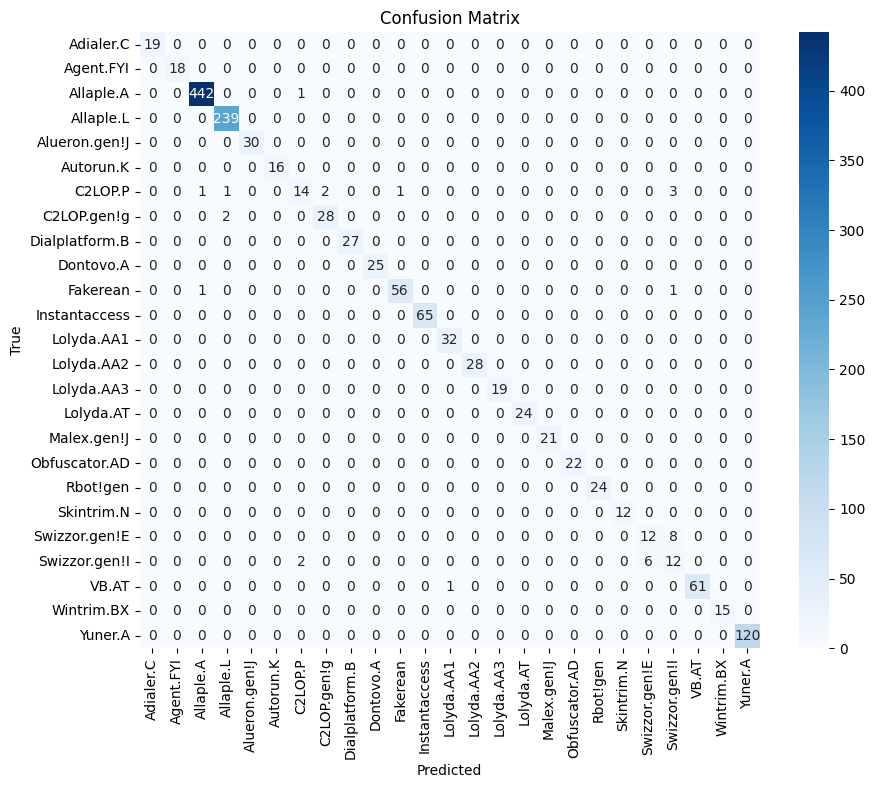

In [36]:
model_name = 'densenet169'
model, preprocess = get_model(model_name, pretrained=False)
train_gen, val_gen, test_gen = get_data_generators(
    'malimg_dataset/train', 'malimg_dataset/val', 'malimg_dataset/test',
    preprocess_input=preprocess
)
history = train_model(model, train_gen, val_gen, model_name=model_name)
evaluate_model(model, test_gen, class_names=list(train_gen.class_indices.keys()))

In [37]:
# Get DenseNet201 Parameter and Size Information
model, preprocess_input = get_model(
    model_name='densenet201',
    input_shape=(64, 64, 3),
    num_classes=25,
    pretrained=False  # or True if testing practical benefit
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 global_average_pooling2d_7  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 1920)              0         
                                                                 
 dense_7 (Dense)             (None, 25)                48025     
                                                                 
Total params: 18370009 (70.08 MB)
Trainable params: 18140953 (69.20 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


Found 6527 images belonging to 25 classes.
Found 1401 images belonging to 25 classes.
Found 1411 images belonging to 25 classes.
Epoch 1/40
51/51 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.7921

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 1] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 1] CPU RAM: 14073.50MB used / 574461.89MB total
51/51 [==============================] - 131s 1s/step - loss: 0.6501 - accuracy: 0.7921 - val_loss: 2.4635 - val_accuracy: 0.4554 - lr: 0.0010
Epoch 2/40
51/51 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9540

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 2] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 2] CPU RAM: 14417.44MB used / 574461.89MB total
51/51 [==============================] - 65s 1s/step - loss: 0.1505 - accuracy: 0.9540 - val_loss: 2.2814 - val_accuracy: 0.4061 - lr: 0.0010
Epoch 3/40
51/51 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9772

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 3] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 3] CPU RAM: 14617.71MB used / 574461.89MB total
51/51 [==============================] - 64s 1s/step - loss: 0.0669 - accuracy: 0.9772 - val_loss: 2.0624 - val_accuracy: 0.5389 - lr: 0.0010
Epoch 4/40
51/51 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9799

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 4] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 4] CPU RAM: 14722.88MB used / 574461.89MB total
51/51 [==============================] - 67s 1s/step - loss: 0.0637 - accuracy: 0.9799 - val_loss: 1.8359 - val_accuracy: 0.6310 - lr: 0.0010
Epoch 5/40
51/51 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9897

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 5] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 5] CPU RAM: 14605.71MB used / 574461.89MB total
51/51 [==============================] - 68s 1s/step - loss: 0.0262 - accuracy: 0.9897 - val_loss: 0.4436 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 6/40
51/51 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9957

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 6] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 6] CPU RAM: 14660.80MB used / 574461.89MB total
51/51 [==============================] - 67s 1s/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.1784 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 7/40
51/51 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9923

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 7] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 7] CPU RAM: 14748.21MB used / 574461.89MB total
51/51 [==============================] - 69s 1s/step - loss: 0.0214 - accuracy: 0.9923 - val_loss: 0.1465 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 8/40
51/51 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9913[Epoch 8] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 8] CPU RAM: 14834.07MB used / 574461.89MB total
51/51 [==============================] - 66s 1s/step - loss: 0.0278 - accuracy: 0.9913 - val_loss: 0.2360 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 9/40
51/51 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9900[Epoch 9] GPU 0: 3.0MB / 81920.0MB used | Load: 0.0%
[Epoch 9] CPU RAM: 14871.67MB used / 574461.89MB total
51/51 [==============================] - 65s 1s/step - loss: 0.0374 - accuracy: 0.9900 - val_loss: 3.1035 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 10/40
51/51 [==============================] - ETA: 0s - l

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 12] GPU 0: 79514.0MB / 81920.0MB used | Load: 0.0%
[Epoch 12] CPU RAM: 18266.06MB used / 574461.89MB total
51/51 [==============================] - 72s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.9807 - lr: 5.0000e-04
Epoch 13/40
51/51 [==============================] - ETA: 0s - loss: 3.7162e-04 - accuracy: 1.0000

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 13] GPU 0: 79516.0MB / 81920.0MB used | Load: 0.0%
[Epoch 13] CPU RAM: 18490.80MB used / 574461.89MB total
51/51 [==============================] - 66s 1s/step - loss: 3.7162e-04 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9829 - lr: 5.0000e-04
Epoch 14/40
51/51 [==============================] - ETA: 0s - loss: 2.1881e-04 - accuracy: 1.0000

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 14] GPU 0: 79548.0MB / 81920.0MB used | Load: 100.0%
[Epoch 14] CPU RAM: 19686.03MB used / 574461.89MB total
51/51 [==============================] - 78s 2s/step - loss: 2.1881e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9843 - lr: 5.0000e-04
Epoch 15/40
51/51 [==============================] - ETA: 0s - loss: 1.7142e-04 - accuracy: 1.0000

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 15] GPU 0: 79548.0MB / 81920.0MB used | Load: 100.0%
[Epoch 15] CPU RAM: 19692.49MB used / 574461.89MB total
51/51 [==============================] - 74s 1s/step - loss: 1.7142e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9836 - lr: 5.0000e-04
Epoch 16/40
51/51 [==============================] - ETA: 0s - loss: 1.1667e-04 - accuracy: 1.0000[Epoch 16] GPU 0: 79572.0MB / 81920.0MB used | Load: 2.0%
[Epoch 16] CPU RAM: 19563.55MB used / 574461.89MB total
51/51 [==============================] - 84s 2s/step - loss: 1.1667e-04 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9843 - lr: 5.0000e-04
Epoch 17/40
51/51 [==============================] - ETA: 0s - loss: 1.1190e-04 - accuracy: 1.0000[Epoch 17] GPU 0: 79572.0MB / 81920.0MB used | Load: 28.0%
[Epoch 17] CPU RAM: 19271.81MB used / 574461.89MB total
51/51 [==============================] - 66s 1s/step - loss: 1.1190e-04 - accuracy: 1.0000 - val_loss: 0.0690 - val_accuracy: 0.9850 - lr: 5.0000e-04
Epoch 18/

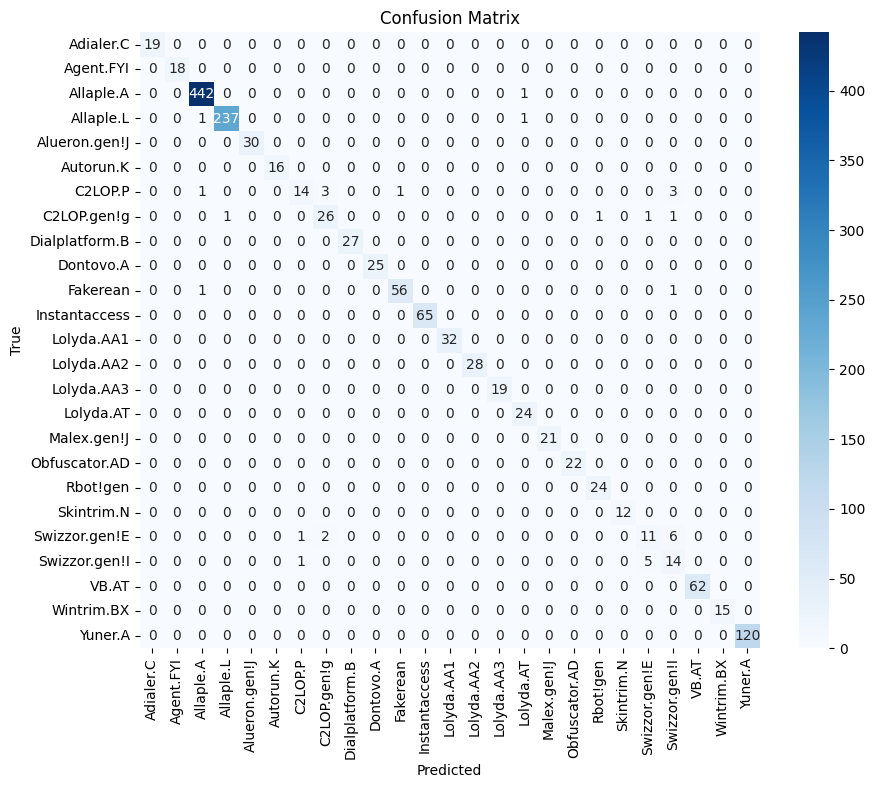

In [38]:
model_name = 'densenet201'
model, preprocess = get_model(model_name, pretrained=False)
train_gen, val_gen, test_gen = get_data_generators(
    'malimg_dataset/train', 'malimg_dataset/val', 'malimg_dataset/test',
    preprocess_input=preprocess
)
history = train_model(model, train_gen, val_gen, model_name=model_name)
evaluate_model(model, test_gen, class_names=list(train_gen.class_indices.keys()))

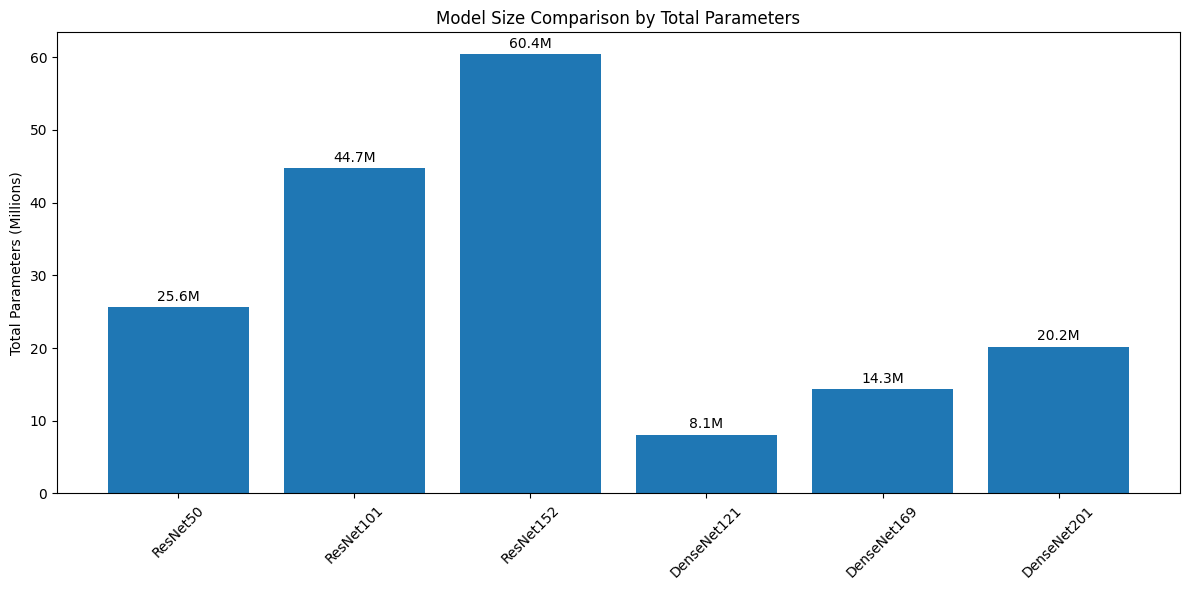

In [40]:
# Plot Parameter Count for each Model:
import matplotlib.pyplot as plt

# Define your model names and their total parameter counts
model_params = {
    "ResNet50": 25.6e6,
    "ResNet101": 44.7e6,
    "ResNet152": 60.4e6,
    "DenseNet121": 8.1e6,
    "DenseNet169": 14.3e6,
    "DenseNet201": 20.2e6,
}

# Extract names and parameter counts
model_names = list(model_params.keys())
params_millions = [p / 1e6 for p in model_params.values()]

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, params_millions)

# Add value labels on top of bars
for bar, val in zip(bars, params_millions):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f"{val:.1f}M", ha='center', va='bottom', fontsize=10)

plt.ylabel("Total Parameters (Millions)")
plt.title("Model Size Comparison by Total Parameters")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
